In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix 
import streamlit as st
df = pd.read_csv('./Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


#### Drop irrelevant columns / duplicates

In [2]:
df=df.drop(columns=['RowNumber','CustomerId','Surname',])
# df=df.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x.fillna(x.mode()[0]))
# Removed missing values operator to improve performance
df=df.drop_duplicates()
df=df.dropna()


In [3]:
# Convert categorical variable(s) into dummy/indicator variables
# categorical_cols = ['Geography', 'Gender']
# instead of coding categorical values, i went back and encoded numerical values

numerical_cols= ['CreditScore', 'Age',
                 'Tenure',
                 'Balance',
                 'NumOfProducts',
                 'HasCrCard',
                 'IsActiveMember',
                 'EstimatedSalary','Exited']

# df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


# Identifies outliers that may influence model results
df = df[(np.abs(stats.zscore(df[numerical_cols])) < 3).all(axis=1)]

In [4]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1


In [5]:
code_prp = df.copy()

In [6]:
# encodes categorical values
encoder = LabelEncoder()
for x in ['Geography', 'Gender']:
    code_prp[x] = encoder.fit_transform(code_prp[x])

In [7]:
code_prp = code_prp.corr()

<Axes: >

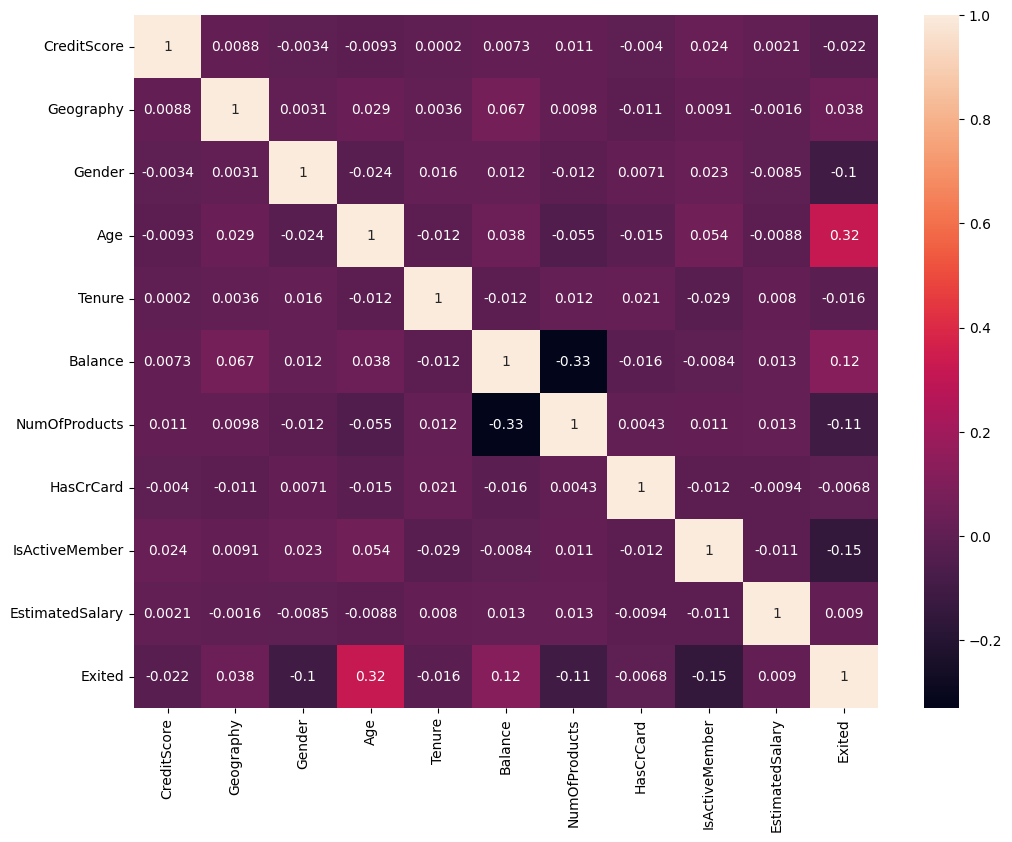

In [8]:
plt.figure(figsize=(12,9))
sns.heatmap(data=code_prp,annot=True)

In [9]:
rf_classifier = RandomForestClassifier(n_estimators=27)

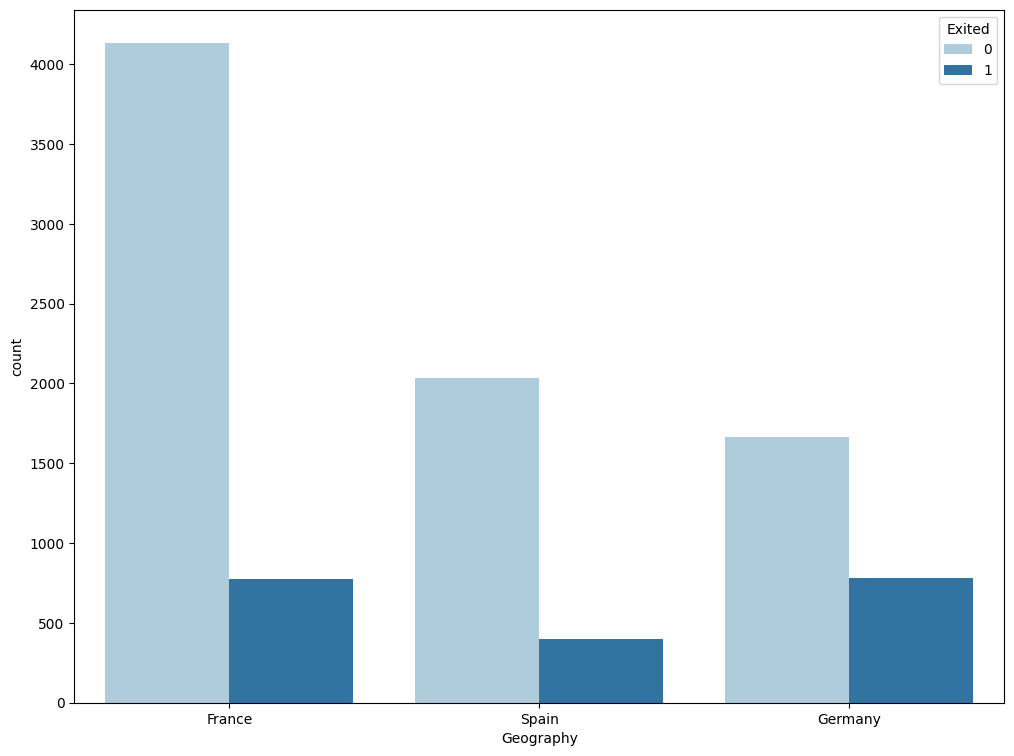

In [10]:
plt.figure(figsize=(12,9))
sns.countplot(data=df, x='Geography', hue='Exited', palette='Paired');

#### Initial RF Model

In [11]:
exited = df[df.Exited==1]
no_exit = df[df.Exited == 0]
upsampled_exited = resample(exited, replace=True, n_samples=len(no_exit))
rf_model = pd.concat([upsampled_exited,no_exit])

In [12]:
# verify Balance
rf_model.Exited.value_counts()

Exited
1    7837
0    7837
Name: count, dtype: int64

In [13]:
for col in ['Geography', 'Gender']:
    rf_model[col] = encoder.fit_transform(rf_model[col])

#### Label Target Attribute

In [14]:
X=rf_model.drop(columns=['Exited'])
y=rf_model['Exited']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=717)

#### Train Model

In [15]:
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(n_estimators=27)

#### Classification Report

In [16]:
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9409888357256778
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1572
           1       0.91      0.98      0.94      1563

    accuracy                           0.94      3135
   macro avg       0.94      0.94      0.94      3135
weighted avg       0.94      0.94      0.94      3135



In [17]:
from sklearn.model_selection import cross_val_score

# Assuming rf_classifier is your model and has been initialized
# X and y have been defined as your features and target variable
scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')  # cv is the number of folds

print("Cross-validated scores:", scores)
print("Average score:", np.mean(scores))


Cross-validated scores: [0.94226475 0.94864434 0.94736842 0.94130781 0.95213784]
Average score: 0.9463446339931746


In [18]:
recall_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='recall')
print("Cross-validated recall scores:", recall_scores)
print("Average recall score:", np.mean(recall_scores))


Cross-validated recall scores: [0.96683673 0.98214286 0.97447352 0.97511168 0.98340779]
Average recall score: 0.9763945144107419


In [19]:
from sklearn.model_selection import cross_validate

scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']
results = cross_validate(rf_classifier, X, y, cv=5, scoring=scoring, return_train_score=False)

print("Test scores:", results['test_accuracy'])
print("Average precision:", np.mean(results['test_precision_macro']))
print("Average recall:", np.mean(results['test_recall_macro']))
print("Average F1 score:", np.mean(results['test_f1_macro']))


Test scores: [0.93779904 0.9476874  0.94322169 0.94066986 0.95022336]
Average precision: 0.9457101277917923
Average recall: 0.9439203257882605
Average F1 score: 0.9438646141297248


#### Cross Validation Average

#### Feature Importance

In [20]:
feature_importances = pd.DataFrame(rf_classifier.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                 importance
Age                0.256779
Balance            0.146584
EstimatedSalary    0.145755
CreditScore        0.133069
NumOfProducts      0.124906
Tenure             0.078604
Geography          0.039146
IsActiveMember     0.036852
Gender             0.020391
HasCrCard          0.017915


In [ ]:
!streamlit run Churn_Prediction_st.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://192.168.0.236:8502

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
2024-05-06 08:44:15.294 Uncaught app exception
Traceback (most recent call last):
  File "/Users/mariovillanueva/anaconda3/envs/mgt4250/lib/python3.11/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 542, in _run_script
    exec(code, module.__dict__)
  File "/Users/mariovillanueva/Documents/Admin/Spring 24'/Data Wrangling/Python Practice/PythonPractice/Project Folder/Churn_Prediction_st.py", line 51, in <module>
    fig = px.bar(df, x='Importance', y='Features', orientation='h', text='Importance')
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mariovillanueva/anaconda3/envs/mgt4250/lib/python3.11/site-packages/plotly/express/_chart_types.py", line 373, in bar
 